In [2]:
import pandas as pd
import numpy as np

In [3]:
ds_train = pd.read_csv('ds/train.csv')
ds_songs = pd.read_csv('ds/songs.csv')
ds_songs_extra_info = pd.read_csv('ds/song_extra_info.csv')
ds_members = pd.read_csv('ds/members.csv')

### Беру только 15% от датасета, потому что построение предложений идут очень долго =(

In [4]:
ds_train = ds_train.sample(frac=0.15)

In [5]:
X_train = ds_train.sample(frac=0.8)
X_test = ds_train.drop(X_train.index)

### В качестве предложений(sentence) для каждого юзера буду рассматривать список песен, которые он лайкнул. Где айдишки песен - слова для word2vec

In [6]:
X_train_pos = X_train[X_train['target'] == 1]

In [7]:
from tqdm.notebook import tqdm, trange

In [8]:
users = np.unique(X_train_pos['msno'].values)
user_pos_history = [X_train_pos[X_train_pos['msno'] == user]['song_id'].astype(str).tolist() for user in tqdm(users)]

In [9]:
from gensim.models import Word2Vec

In [10]:
lengths = [len(arr) for arr in user_pos_history]
np.mean(lengths)

19.142771213748656

In [11]:
w2v = Word2Vec(window=8, sg=1, hs=0, negative=15, alpha=0.05)

In [12]:
w2v.build_vocab(user_pos_history)

In [13]:
w2v.train(user_pos_history, total_examples=len(user_pos_history), epochs=30)

(10660338, 13366440)

In [14]:
ds_songs = ds_songs.merge(ds_songs_extra_info,on='song_id',how='left')

In [15]:
ds_songs.shape

(2296320, 9)

In [16]:
print(w2v)

Word2Vec(vocab=12324, vector_size=100, alpha=0.05)


In [17]:
def get_similars(name):
    sims = w2v.wv.most_similar_cosmul(name)
    data = []
    for song, similarity in sims:
        d = ds_songs[ds_songs['song_id'] == song].to_dict('records')[0]
        d['similarity'] = similarity
        data.append(d)
    return pd.DataFrame(data)

In [18]:
# name = '0ee/D6HjX0jSytUn3v58C0x6zEzN4bcPq3WlqvrG/Xo=' # heathens, Twenty one pilots
name = 'e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=' # Shape of you
print(name)
get_similars(name)

e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,similarity
0,0b8M2FLEH176y/ng1rK9ftUYDYnA+1NdoCOUeuyBMtU=,221544,1609,The Chainsmokers,Andrew Taggart| Kris Eriksson| Fredrik Häggstam,Andrew Taggart| Kris Eriksson| Fredrik Häggstam,52.0,Paris,USQX91603031,0.834616
1,n+FLlTL+LrNTa6xpoGkESEzlUMb/hPEM1nLq2U6fEp0=,261172,465,Ed Sheeran,Ed Sheeran| Benjamin Levin,NaN,52.0,Castle on the Hill,GBAHS1600462,0.806091
2,+LztcJcPEEwsikk6+K5udm06XJQMzR4+lzavKLUyE0k=,208492,1609,The Chainsmokers,Andrew Taggart| Emily Warren| Scott Harris,Andrew Taggart| Emily Warren| Scott Harris,52.0,Don't Let Me Down,USQX91600011,0.804529
3,o9HWMBZMeIPnYEpSuscGoORKE44sj3BYOdvGuIi0P68=,309394,458,Eric 周興哲,Eric周興哲,王仲宇/Eric周興哲,3.0,愛在身邊 (Unbreakable Love),TWA471701001,0.801999
4,sgHKhG2d57U2o88razl9SyG1nuuMDf0J2BuDhzoI12Y=,194115,1609,The Chainsmokers,Andrew Taggart| Sara Hejellstrom| Nirob Islam,Andrew Taggart| Sara Hejellstrom| Nirob Islam,52.0,All We Know,USQX91602153,0.799447
5,Xpjwi8UAE2Vv9PZ6cZnhc58MCtl3cKZEO1sdAkqJ4mo=,281495,458,田馥甄 (Hebe),薛之謙,薛之謙,3.0,演員,TWD951676105,0.797303
6,9YYrODwrXpDcCjOJypHROv3f5z40y11QlmgQjmzp2vQ=,183379,1616|1609,Mike Perry,Mikael Persson| Sara Hjellström| Dimitri Vange...,Mikael Persson| Sara Hjellström| Nirob Islam,52.0,The Ocean,SE3AA1600005,0.796575
7,limwLMOy3/jAQ5dOa3x7k/eJmA1ARXel99C337h+E34=,211278,465,James Arthur,James Arthur| Steve Solomon| Neil Ormandy,James Arthur| Steve Solomon| Neil Ormandy,52.0,Say You Won't Let Go,DEE861600586,0.784738
8,MtFK4NN8Kv1k/xPA3wb8SQaP/jWee52FAaC1s9NFsU4=,222197,1609,Calvin Harris,Calvin Harris| Taylor Swift,Calvin Harris| Taylor Swift,52.0,This Is What You Came For,GBARL1600460,0.783080
9,IKMFuL0f5Y8c63Hg9BXkeNJjE0z8yf3gMt/tOxF4QNE=,244976,1609,The Chainsmokers,Andrew Taggart| Shaun Frank| Frederic Kennett|...,Andrew Taggart| Shaun Frank| Frederic Kennett|...,52.0,Closer,USQX91601347,0.781835


In [19]:
song_data_name_author = []
songs_in_dict = list(w2v.wv.key_to_index.keys())
# for song_id in tqdm(w2v.wv.key_to_index.keys()):
#     print(song_id, ds_songs[ds_songs['song_id'] == song_id]['name'], ds_songs[ds_songs['song_id'] == song_id]['artist_name'])
#     song_data_name_author.append((song_id, ds_songs[ds_songs['song_id'] == song_id]['name'], ds_songs[ds_songs['song_id'] == song_id]['artist_name']))

In [20]:
# w2v.wv.get_vector("e/upMhPFcXl3Rxq0Us1abr0FcThlZOeqKJhBobmltBU=",norm=True)

In [21]:
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

In [22]:
def get_user_embeddings(X, y):
    embeddings = dict()
    count = dict()
    for (index, row), target in tqdm(zip(X_train.iterrows(), y_train)):
        if target == 1:
            user_id = row['msno']
            song_id = row['song_id']
            if song_id in songs_in_dict:
                if user_id not in count:
                    count[user_id] = 0
                if user_id not in embeddings:
                    embeddings[user_id] = np.zeros(100)
                embeddings[user_id] += w2v.wv.get_vector(song_id, norm=True)
                count[user_id] += 1
    for user_id in embeddings.keys():
        embeddings[user_id] /= count[user_id]
    return embeddings    

In [23]:
user_embeddings = get_user_embeddings(X_train, y_train)

In [24]:
def get_user_song_dot(user_id, song_id):
    if user_id not in user_embeddings:
        return 0
    if song_id not in songs_in_dict:
        return 0
    uv = user_embeddings[user_id]
    sv = w2v.wv.get_vector(song_id)
    
    u_n = np.linalg.norm(uv)
    s_n = np.linalg.norm(sv)
    return np.dot(uv / u_n, sv / s_n)

In [25]:
X_test_c = X_test.copy()

In [26]:
target_res = []
for index, row in tqdm(X_test_c.iterrows()):
    user_id = row['msno']
    song_id = row['song_id']
    target_res.append(get_user_song_dot(user_id, song_id))

### Результат хуже, чем у бустинга, вероятно мало данных, и много пропущенных песен

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, target_res)

0.6303801222110809

# Добавим эти данные к GBDT 

In [28]:
# ds_train = pd.read_csv('ds/train.csv')
# ds_songs = pd.read_csv('ds/songs.csv')
# ds_songs_extra_info = pd.read_csv('ds/song_extra_info.csv')
# ds_members = pd.read_csv('ds/members.csv')

## (Дальше немного пойдет копипаста 1 части)

In [29]:
genres_for_song = ds_songs['genre_ids'].apply(lambda x: [int(v) for v in str(x).split('|') if v != 'nan'])

In [30]:
genres = dict()
for genre_list in genres_for_song:
    for g in genre_list:
        if g not in genres:
            genres[g] = 0
        genres[g] += 1

In [31]:
sorted_genres = {k: v for k, v in reversed(sorted(genres.items(), key=lambda item: item[1]))}
sorted_genres['0'] = -1

In [32]:
def get_most_popular(g_list):
    res = '0'
    for g in g_list:
        if sorted_genres[res] < sorted_genres[g]:
            res = g
    return res

In [33]:
most_pop = []
for genre_list in genres_for_song:
    most_pop.append(get_most_popular(genre_list))

In [34]:
ds_songs['genre_ids'] = most_pop

In [35]:
def leave_first(column):
    items = ds_songs[column].apply(lambda x: [v for v in str(x).split('|')])
    res = [v[0] for v in items]
    ds_songs[column] = res

In [36]:
leave_first('artist_name')
leave_first('composer')
leave_first('lyricist')

In [37]:
ds_train = ds_train.merge(ds_members,on='msno',how='left')
ds_train = ds_train.merge(ds_songs,on='song_id',how='left')
ds_train = ds_train.fillna(0)

In [38]:
ds_train.drop(columns=['registration_init_time','expiration_date','song_length'], inplace=True)

In [39]:
ds_train['language'] = ds_train['language'].astype(int).astype('category')
ds_train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,cqmFueF5y1pLXlBTMvPJbkbnJBu8YRneung0Ucd08pU=,iJI/Hb+Fl6iTlICmCKjV3vQTVJH1wnYVm561SB5Mheg=,my library,Local playlist more,local-library,1,6,30,male,9,465,信樂團 (Shin Band),Keith Stuart,方文山,3,千年之戀,TWA770400202
1,2AuaeP5blev17Z+QKcNOI7TSRywy1UDgo+SBrH5Cpco=,giLg43LpLYtKJj8aKQehu0auImYZpfPgA3gycfKgupg=,discover,Album more,album,0,8,22,male,7,458,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),兄弟本色G.U.T.S,兄弟本色G.U.T.S,3,WE WILL RULE 背水一戰,TWA451650901
2,4BqfqwwMFLqdNw67y6WrezLNZcla6uV/14nvtpuHa2A=,yhUWLTICqIv17CRI2472lJN+GWFhyHoRy7uzDykzKM0=,discover,0,top-hits-for-artist,1,1,0,0,4,465,George Michael,nan,nan,52,Last Christmas,GBARL0601611


In [40]:
def get_dots(row):
    user_id = row['msno']
    song_id = row['song_id']
    return get_user_song_dot(user_id, song_id)

In [41]:
ds_train['dot'] = ds_train.apply(lambda row: get_dots(row), axis=1)

In [42]:
X_train=ds_train.sample(frac=0.8)
X_test=ds_train.drop(X_train.index)

In [43]:
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

In [44]:
ds_train.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,genre_ids,artist_name,composer,lyricist,language,name,isrc,dot
0,cqmFueF5y1pLXlBTMvPJbkbnJBu8YRneung0Ucd08pU=,iJI/Hb+Fl6iTlICmCKjV3vQTVJH1wnYVm561SB5Mheg=,my library,Local playlist more,local-library,1,6,30,male,9,465,信樂團 (Shin Band),Keith Stuart,方文山,3,千年之戀,TWA770400202,0.457657
1,2AuaeP5blev17Z+QKcNOI7TSRywy1UDgo+SBrH5Cpco=,giLg43LpLYtKJj8aKQehu0auImYZpfPgA3gycfKgupg=,discover,Album more,album,0,8,22,male,7,458,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),兄弟本色G.U.T.S,兄弟本色G.U.T.S,3,WE WILL RULE 背水一戰,TWA451650901,0.442302


In [45]:
X_train = X_train.drop(columns=['source_system_tab','source_screen_name','source_type','city','registered_via','isrc','name'])
X_test = X_test.drop(columns=['source_system_tab','source_screen_name','source_type','city','registered_via','isrc','name'])

In [46]:
X_train.head(2)

,msno,song_id,bd,gender,genre_ids,artist_name,composer,lyricist,language,dot
268652,q4bs6leMECazAnauABtGtzIwnlvgAzl9xQgQj+iXbec=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,17,male,458,楊凱琳 (Rosie),艾怡良,黃祖蔭/余琛懋,3,0.350295
858841,v2mlXIfg5CD4mdF14b4vDDlvkQhb0LTE/kpIX9dgtBM=,KI7z8qz9vNMQFIAaNcTjooCYZd8AZ9DHRk7R2VjnI5A=,0,0,921,Harry Potter,John Williams,nan,52,0.000000


In [47]:
from catboost import CatBoostClassifier

In [48]:
cat_features = [0, 1, 3, 4, 5, 6, 7, 8]

In [49]:
clf = CatBoostClassifier(iterations=200, verbose=20, cat_features=cat_features)

In [50]:
clf.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.5514064	total: 2.04s	remaining: 6m 45s
20:	learn: 0.4269024	total: 28.6s	remaining: 4m 3s
40:	learn: 0.4204123	total: 50.2s	remaining: 3m 14s
60:	learn: 0.4165492	total: 1m 16s	remaining: 2m 53s
80:	learn: 0.4139222	total: 1m 44s	remaining: 2m 33s
100:	learn: 0.4128582	total: 2m 8s	remaining: 2m 5s
120:	learn: 0.4121668	total: 2m 28s	remaining: 1m 37s
140:	learn: 0.4110987	total: 2m 49s	remaining: 1m 10s
160:	learn: 0.4099872	total: 3m 11s	remaining: 46.4s
180:	learn: 0.4092582	total: 3m 31s	remaining: 22.3s
199:	learn: 0.4087498	total: 3m 54s	remaining: 0us


In [51]:
prediction = clf.predict(X_test)

In [52]:
print(roc_auc_score(y_test, prediction))

0.8180810744455458


In [53]:
import shap  # package used to calculate Shap values

In [54]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

In [55]:
# Calculate Shap values
shap_values = explainer.shap_values(X_test)

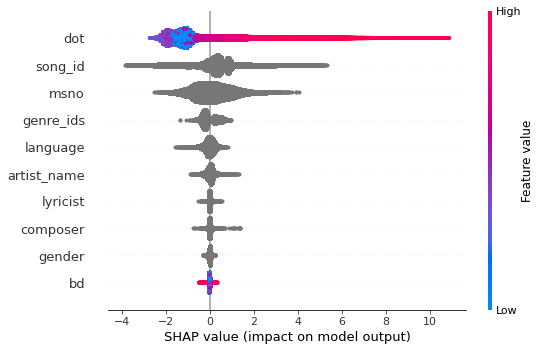

In [56]:
shap.summary_plot(shap_values, X_test)

### dot - самый важный признак

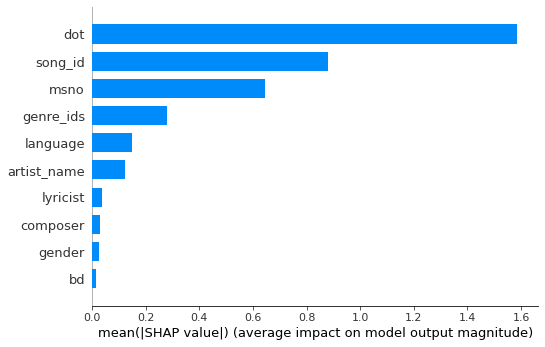

In [57]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [58]:
X_train.head(10)

,msno,song_id,bd,gender,genre_ids,artist_name,composer,lyricist,language,dot
268652,q4bs6leMECazAnauABtGtzIwnlvgAzl9xQgQj+iXbec=,KcQ4assZxaXsdizqxGjUSAY7CNc6+6hQzpVsjnWsShQ=,17,male,458,楊凱琳 (Rosie),艾怡良,黃祖蔭/余琛懋,3,0.350295
858841,v2mlXIfg5CD4mdF14b4vDDlvkQhb0LTE/kpIX9dgtBM=,KI7z8qz9vNMQFIAaNcTjooCYZd8AZ9DHRk7R2VjnI5A=,0,0,921,Harry Potter,John Williams,nan,52,0.000000
429955,dZNojW/n4mqxR6RSZt4CMeCnJzzxBYi6n9qQCKbghvE=,pDZyGrBY477Mxs3a4//7hgLyFYWd9nbzKefFYtZ7Tlg=,26,female,465,溫嵐 (Landy Wen),吳克群,吳克群,3,0.495239
758726,oep9ywD1QlH2/JXdQ4I/T63g7i5yfaZXlPogr7H0vio=,euRPd0QK1N6YMx48rLV5bs3G7WYj+lpKWgE293Urh5Q=,30,male,465,A-Lin,Lee Hyun Jeong,Lee Kyeong Nam,3,0.311578
625417,unuBjdkup2r/oiI8h7cNIRWAlleTCsjaYMnFWb25qoA=,CfRfhBa6yM8nq25eFOCdFeuIaWtU9sVPi4YuBRHt0XY=,25,male,465,范瑋琪 (Christine Fan),黃丹儀,陳淑和,3,0.230186
376777,YTVaW102vZnK0RMH+Krc/7X9bB56yD080pAIn0FOD8M=,M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=,19,male,465,林俊傑 (JJ Lin),JJ Lin,Lin Qiu Li,3,0.488962
199603,EFnGqkXBEurexJDYlFv3rjz14DlqsQOLOnHnyNPdtw0=,SGq9z/915UK7lh2/JXkFA/pxerqrkDFtnhlZFc/G5R0=,26,male,921,Crush,nan,nan,31,0.366048
286149,6bwk5TTaA1YSOmPoxDgBBlV5CrZJEar2C6SxwT5nDrU=,MlRnS/kguZ56UFejtWP/ib9zQMEJnsV5wFPr7sM9MIE=,32,male,465,嚴爵 (Yen-j),嚴爵,嚴爵,3,0.453547
198783,8kkU82JaU54SwSqoc/gTAPUT1JqLJhqJfLPPQNeILIE=,6LdT9BiGIlQ3rJped7PACqnrzstFXz8dXD6MmmsA8uI=,27,female,465,陳奕迅 (Eason Chan),Christopher Chak,nan,3,0.682179
460681,H/MB+uttGlGIMr7qru4HYG4dVbh0e1mBuoryBOKz/RU=,TdvzCUfK+yPymRSabpVGPdFKLaAs3/uQ0gaRGozwiSw=,25,male,465,鄭秀文 (Sammi Cheng),Choi Joon Young,Liao Ying Ru,3,0.368319
